<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/John-staging/Notebooks/How_to_build_an_RNAseq_logistic_regression_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to build an RNA-seq logistic regression classifier
Check out other notebooks at our [Community Notebooks Repository](https://github.com/isb-cgc/Community-Notebooks)!

- **Title:** How to build an RNA-seq logistic regression classifier
- **Author:** John Phan
- **Created:** 2021-07-07
- **Purpose:** Demonstrate a basic machine learning method to predict a cancer endpoint using gene expression data.
- **URL:** https://github.com/isb-cgc/Community-Notebooks
- **Note1:** This example is based on the work published by [Bosquet et al.](https://molecular-cancer.biomedcentral.com/articles/10.1186/s12943-016-0548-9)


This notebook demonstrates how to build a basic machine learning model to predict ovarian cancer treatment outcome. Ovarian cancer gene expression data is pulled from a BigQuery table and formatted using Pandas. The data is then split into training and testing sets to build and test a logistic regression classifier using scikit-learn. 

## Import Dependencies

In [ ]:
# GCP libraries
from google.cloud import bigquery
from google.colab import auth

# Pandas
import pandas as pd

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Visualization
import seaborn as sns


## Authenticate

Before using BigQuery, we need to get authorization for access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html). Alternative authentication methods can be found [here](https://googleapis.dev/python/google-api-core/latest/auth.html).

In [ ]:
# if you're using Google Colab, authenticate to gcloud with the following
auth.authenticate_user()

# alternatively, use the gcloud SDK
#!gcloud auth application-default login

## Parameters

Customize the following parameters based on your notebook, execution environment, or project.

In [ ]:
# set the google project that will be billed for this notebook's computations
google_project = 'my-google-project'

# in this example, we'll be using the Ovarian cancer TCGA dataset
cancer_type = 'TCGA-OV'

# gene expression data will be pulled from this BigQuery project
bq_project = 'isb-cgc-bq'

## BigQuery Client

Create the BigQuery client

In [ ]:
# Create a client to access the data within BigQuery
client = bigquery.Client(google_project)

## Get Gene Expression Data from Big Query Table

Pull RNA-seq gene expression data from the TCGA RNA-seq BigQuery table and join it with the clinical data table to create a labeled data frame. In this example, we will label the samples based on therapy outcome. "Complete Remission/Response" will be labeled as "1" while all other therapy outcomes will be labeled as "0". This prepares the data for binary classification. 

Prediction modeling with RNA-seq data typically requires a feature selection step to reduce the dimensionality of the data before training a classifier. However, to simplify this example, we will use a pre-identified set of 33 genes (Bosquet et al. identified 34 genes, but PRSS2 and its aliases are not available in the hg38 RNA-seq data). 

In [ ]:
ge_data = client.query(("""
  SELECT
    ge.case_barcode AS sample,
    labels.response_label AS label,
    ge.gene_name AS gene_name,
    -- Multiple samples may exist per case, take the max value
    MAX(LOG(ge.HTSeq__FPKM_UQ+1)) AS gene_expression
  FROM `{bq_project}.TCGA.RNAseq_hg38_gdc_current` AS ge
  INNER JOIN (
    SELECT
      *
    FROM (
      SELECT
        case_barcode,
        primary_therapy_outcome_success,
        CASE
          -- Complete Reponse    --> label as 1
          -- All other responses --> label as 0
          WHEN primary_therapy_outcome_success = 'Complete Remission/Response' THEN 1
          WHEN (primary_therapy_outcome_success IN (
            'Partial Remission/Response','Progressive Disease','Stable Disease'
          )) THEN 0
        END AS response_label
        FROM `{bq_project}.TCGA_versioned.clinical_gdc_2019_06`
        WHERE
          project_short_name = '{cancer_type}'
          AND primary_therapy_outcome_success IS NOT NULL
    )
  ) labels
  ON labels.case_barcode = ge.case_barcode
  WHERE gene_name IN ( -- 33 Gene signature, leave out PRSS2 (aka TRYP2)
    'RHOT1','MYO7A','ZBTB10','MATK','ST18','RPS23','GCNT1','DROSHA','NUAK1','CCPG1',
    'PDGFD','KLRAP1','MTAP','RNF13','THBS1','MLX','FAP','TIMP3','PRSS1','SLC7A11',
    'OLFML3','RPS20','MCM5','POLE','STEAP4','LRRC8D','WBP1L','ENTPD5','SYNE1','DPT',
    'COPZ2','TRIO','PDPR'
  )
  GROUP BY sample, label, gene_name
""").format(bq_project=bq_project, cancer_type=cancer_type)).result().to_dataframe()

print(ge_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8712 entries, 0 to 8711
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample           8712 non-null   object 
 1   label            8712 non-null   int64  
 2   gene_name        8712 non-null   object 
 3   gene_expression  8712 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 272.4+ KB
None


## Reshape the Data

The data pulled from BigQuery is formatted such that each row corresponds to a sample/gene combination. However, to use the data with scikit-learn, it is more convenient to reshape the data such that each row corresponds to a sample and each column corresponds to a gene. We'll use Pandas to pivot the data.

In [ ]:
ge_data_pivot = ge_data.pivot(index=('sample', 'label'), columns='gene_name', values='gene_expression').reset_index(level=['sample','label'])
print(ge_data_pivot.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 35 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sample   264 non-null    object 
 1   label    264 non-null    int64  
 2   CCPG1    264 non-null    float64
 3   COPZ2    264 non-null    float64
 4   DPT      264 non-null    float64
 5   DROSHA   264 non-null    float64
 6   ENTPD5   264 non-null    float64
 7   FAP      264 non-null    float64
 8   GCNT1    264 non-null    float64
 9   KLRAP1   264 non-null    float64
 10  LRRC8D   264 non-null    float64
 11  MATK     264 non-null    float64
 12  MCM5     264 non-null    float64
 13  MLX      264 non-null    float64
 14  MTAP     264 non-null    float64
 15  MYO7A    264 non-null    float64
 16  NUAK1    264 non-null    float64
 17  OLFML3   264 non-null    float64
 18  PDGFD    264 non-null    float64
 19  PDPR     264 non-null    float64
 20  POLE     264 non-null    float64
 21  PRSS1    264 non

## Prepare the Data for Prediction Modeling

Prepare the data by splitting it into training and testing sets, and scaling the data. It is important that prediction models are tested on samples that are independent from the training samples in order to accurately estimate performance. 

In [ ]:
# remove the sample names column from the data frame
ge_data_pivot_nosample = ge_data_pivot.drop(labels='sample',axis=1)

# split data into train and test sets, 50% in train and 50% in test. 
# The "random_state" variable can be used to reproduce the split
train_data = ge_data_pivot_nosample.sample(frac=0.5, random_state=1).sort_index()

# the test data is what remains after removing the train data
test_data = ge_data_pivot_nosample.drop(train_data.index)

# move labels to their own variables
train_y = train_data.pop('label')
test_y = test_data.pop('label')

# using scikit-learn, scale the data to 0 mean and unit variance. This is
# required for some machine learning methods.
scaler = StandardScaler()

# store the scaled data, and the scaler, in the dict
train_x = scaler.fit_transform(train_data)
test_x = scaler.transform(test_data)

# print stats of train and test dataset
print('Train Data: ')
print("\tComplete Remission/Response: ", sum(train_y==1))
print("\tOther Response: ", sum(train_y==0))

print('Test Data: ')
print("\tComplete Remission/Response: ", sum(test_y==1))
print("\tOther Response: ", sum(test_y==0))


Train Data: 
	Complete Remission/Response:  87
	Other Response:  45
Test Data: 
	Complete Remission/Response:  91
	Other Response:  41


## Train and Test the Prediction Model

We use a simple logistic regression classifier implemented by scikit-learn. More information about the classifier can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). After training the classifier using the "fit" function, we use the "decision_function" to predict a decision value for each sample in the test dataset. Because the dataset is not balanced in terms of the number of samples in each class, we use AUC, or Area Under the ROC curve, to assess prediction performance. The decision values are used to calculate the AUC, with higher AUC values indicating better prediction performance. An AUC of 1 indicates perfect prediction. More information about accuracy, AUC, and other classification performance metrics can be found in the [Google Machine Learning crash course](https://developers.google.com/machine-learning/crash-course/classification/video-lecture). Read about AUC [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).  

In [ ]:
# train a logistic regression model
lr = LogisticRegression(max_iter=1000, solver='liblinear', C=0.1)
lr.fit(train_x, train_y)

# predict samples in the test set
pred = lr.decision_function(test_x)

# calculate the ROC curve and AUC in order to gauge prediction performance
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred)
auc = metrics.auc(fpr, tpr)

print('Prediction Performance (AUC):', auc)

Prediction Performance (AUC): 0.7424283034039132


## Evaluate Prediction Performance

The prediction performance AUC of 0.74 is within the performance range (0.7 to 0.8) of the models developed by [Bosquet et al.](https://molecular-cancer.biomedcentral.com/articles/10.1186/s12943-016-0548-9). Note that if the "random_state" value is changed in the train/test split step, prediction performance will vary. Thus, a better method for assessing performance would be to generate multiple permutations of train/test datasets, calculate prediction performance for each permutation, and report the mean and standard deviation of AUC. 

In [ ]:
num_iters = 10
auc_vals = []

for i in range(num_iters):
  # randomly split data into train and test sets, 50% in train and 50% in test. 
  train_data = ge_data_pivot_nosample.sample(frac=0.5).sort_index()

  # the test data is what remains after removing the train data
  test_data = ge_data_pivot_nosample.drop(train_data.index)

  # move labels to their own variables
  train_y = train_data.pop('label')
  test_y = test_data.pop('label')

  # the data must be scaled every time a new train/test split is created
  scaler = StandardScaler()
  train_x = scaler.fit_transform(train_data)
  test_x = scaler.transform(test_data)

  # train a logistic regression model
  lr = LogisticRegression(max_iter=1000, solver='liblinear', C=0.1)
  lr.fit(train_x, train_y)

  # predict samples in the test set
  pred = lr.decision_function(test_x)

  # calculate the ROC curve and AUC in order to gauge prediction performance
  fpr, tpr, thresholds = metrics.roc_curve(test_y, pred)
  auc_vals.append(metrics.auc(fpr, tpr))

print('AUC Values:', auc_vals)
print('AUC Mean:', pd.Series(auc_vals).mean())
print('AUC Standard Deviation:', pd.Series(auc_vals).std())

AUC Values: [0.6000000000000001, 0.6500638569604087, 0.6557734204793029, 0.6465581977471839, 0.6989130434782609, 0.5891534391534392, 0.676509014894173, 0.708910373660831, 0.6907407407407408, 0.6898382204246714]
AUC Mean: 0.6606460307539013
AUC Standard Deviation: 0.040724882243533794


## Visualize and Interpret Results

We can use data visualization to help interpret the classifier's performance. Although our initial prediction result was 0.74, the average prediction result over several random permutations of the data is actually below 0.7, with a range spanning approximately 0.6 to 0.7. An AUC of 0.7 can be interpreted as a 70% chance that the classifier's prediction (i.e., "Complete Remission/Response" or not) is correct. 

[(-1.0, 1.0),
 Text(0, 0.5, 'Logistic Regression'),
 (0.0, 1.0),
 Text(0.5, 0, 'AUC')]

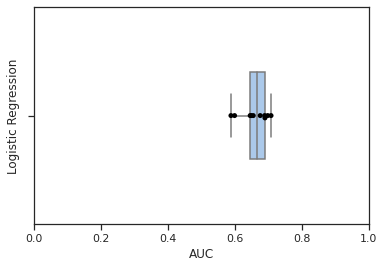

In [ ]:
# use seaborn to generate a box plot of AUC results
sns.set_theme(style='ticks', palette='pastel')
ax = sns.boxplot(x=auc_vals)
ax = sns.swarmplot(x=auc_vals, color="0")
ax.set(xlim=(0,1), ylim=(-1,1),xlabel='AUC',ylabel='Logistic Regression')

## Next Steps

The model trained and stored in the "lr" variable can now be used to predict therapeutic outcome of future RNA-seq ovarian cancer samples. If the model "lr" has been trained to generalize well to the problem of predicting Ovarian cancer therapeutic outcome, we would expect that future predictions would yield a 70% probability of being correct. However, an inherent problem with estimating machine learning performance is its dependence on the data. Thus, if future RNA-seq samples differ significantly from the training and testing data, we cannot make any assumptions about the "lr" model's prediction of those samples.